In [4]:
print(sys.executable)  # Should show your venv Python path

d:\UCSD_CodeAlong_Cats_Dogs\venv\Scripts\python.exe


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [33]:
# organize data into train, valid, test dirs
from os import makedirs
from os import listdir
from pathlib import Path

data_dir = Path(r"D:\UCSD_CodeAlong_Cats_Dogs\Data")
cat_data_dir = Path(r"D:\UCSD_CodeAlong_Cats_Dogs\Data\Cat")
dog_data_dir = Path(r"D:\UCSD_CodeAlong_Cats_Dogs\Data\Dog")

os.chdir(data_dir)
working_dir = os.getcwd()
print(working_dir)
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

D:\UCSD_CodeAlong_Cats_Dogs\Data


In [34]:
os.chdir(data_dir)

In [21]:
for c in random.sample(list(cat_data_dir.glob('*.jpg')), 500):
    shutil.move(c, 'train/cat')
for c in random.sample(list(dog_data_dir.glob('*jpg')), 500):
    shutil.move(c, 'train/dog')
for c in random.sample(list(cat_data_dir.glob('*jpg')), 100):
    shutil.move(c, 'valid/cat')
for c in random.sample(list(dog_data_dir.glob('*jpg')), 100):
    shutil.move(c, 'valid/dog')
for c in random.sample(list(cat_data_dir.glob('*jpg')), 50):
    shutil.move(c, 'test/cat')
for c in random.sample(list(dog_data_dir.glob('*jpg')), 50):
    shutil.move(c, 'test/dog')



In [36]:
os.chdir('../')
working_dir = os.getcwd()
print(working_dir)

D:\UCSD_CodeAlong_Cats_Dogs


In [37]:
# Make Paths
train_path = Path(r'data/train')
valid_path = Path(r'data/valid')
test_path = Path(r'data/test')

In [38]:
# Prepare Data
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [40]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [41]:
# Grab one batch 
imgs, labels = next(train_batches)

In [42]:
# This function will plot images in the form of a grid with 1 row and 10 cols 
def plot_images(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-95.68..140.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..148.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-107.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-97.68..144.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..151.061].
Clipping input data t

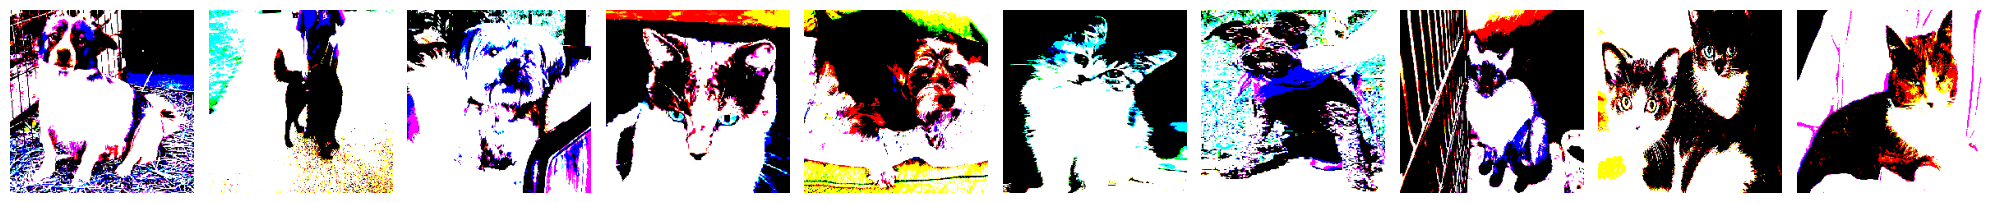

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [43]:
plot_images(imgs)
print(labels)